# Final Project - Advanced Deep Learning

### Data Preparation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import zipfile
import requests

def download_file(url, local_filename):
    # Check if file already exists locally
    if os.path.exists(local_filename):
        print(f"{local_filename} already exists locally.")
        return

    # Download the file
    with requests.get(url, stream=True) as response:
        response.raise_for_status()  # Ensure we raise an error for bad responses
        with open(local_filename, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
    print(f"Downloaded {local_filename} from {url}.")


def unzip_file(zip_filepath, extract_to):
    # Check if the extracted directory already exists
    if os.path.isdir(extract_to):
        print(f"Directory {extract_to} already exists. Skipping extraction.")
        return

    # Unzip the file
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {zip_filepath} to {extract_to}.")



# this url is available for only a limited time.
dataset_url = "http://t12s-418866851410-ltu-adl.s3-website.eu-central-1.amazonaws.com/chest_xray.zip"
local_zip_filename = "/tmp/chest_xray.zip"
extract_to = "/tmp/ltu-chest-xray"

# Download the file if not already downloaded
download_file(dataset_url, local_zip_filename)

# Unzip the file if not already unzipped
unzip_file(local_zip_filename, extract_to)

# Define directories
train_dir = '/tmp/ltu-chest-xray/chest_xray/train/'
val_dir = '/tmp/ltu-chest-xray/chest_xray/val/'
test_dir = '/tmp/ltu-chest-xray/chest_xray/test/'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


/Users/akshaymalviya/Lulea/LuleaPythonVenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Model Development

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

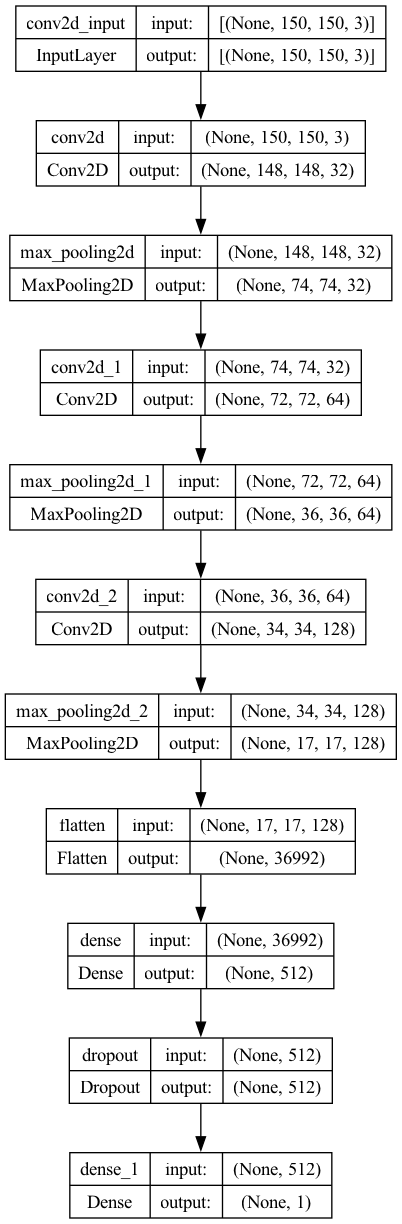

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)


In [3]:
# Tensorboard
import datetime
import os
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [4]:
# Model checkpoint callback to save the best model
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model-{epoch:02d}-{val_accuracy:.2f}.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

### Training

In [5]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
    validation_data=val_generator,
    validation_steps=max(1, val_generator.samples // val_generator.batch_size),
    epochs=25,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/25
163/163 [==============================] - 87s 532ms/step - loss: 0.5060 - accuracy: 0.7673 - val_loss: 0.8313 - val_accuracy: 0.6875
Epoch 2/25
163/163 [==============================] - 88s 538ms/step - loss: 0.3136 - accuracy: 0.8620 - val_loss: 0.8815 - val_accuracy: 0.6250
Epoch 3/25
163/163 [==============================] - 88s 538ms/step - loss: 0.2734 - accuracy: 0.8786 - val_loss: 0.5353 - val_accuracy: 0.8125
Epoch 4/25
163/163 [==============================] - 87s 530ms/step - loss: 0.2525 - accuracy: 0.8965 - val_loss: 0.8867 - val_accuracy: 0.6875
Epoch 5/25
163/163 [==============================] - 86s 528ms/step - loss: 0.2520 - accuracy: 0.8915 - val_loss: 0.5050 - val_accuracy: 0.8125
Epoch 6/25
163/163 [==============================] - 86s 526ms/step - loss: 0.2362 - accuracy: 0.8997 - val_loss: 0.6807 - val_accuracy: 0.8125
Epoch 7/25
163/163 [==============================] - 87s 530ms/step - loss: 0.2313 - accuracy: 0.9038 - val_loss: 1.1054 - val_ac

In [6]:
# Save the final model
model.save('final_model.keras')

### Evaluation

In [7]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, steps=max(1, test_generator.samples // test_generator.batch_size))
print(f'Test Accuracy: {test_acc}')

# Predict the labels for test set
Y_pred = model.predict(test_generator, steps=(test_generator.samples // test_generator.batch_size) + 1)
y_pred = np.round(Y_pred).astype(int)

# Ensuring y_pred matches the number of test samples
y_pred = y_pred[:test_generator.samples]

y_true = test_generator.classes

# Calculate F-score
from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


19/19 [==============================] - 5s 220ms/step - loss: 0.2984 - accuracy: 0.8914
Test Accuracy: 0.8914473652839661
20/20 [==============================] - 5s 207ms/step
F1 Score: 0.9164556962025316
Precision: 0.905
Recall: 0.9282051282051282


### Visualization

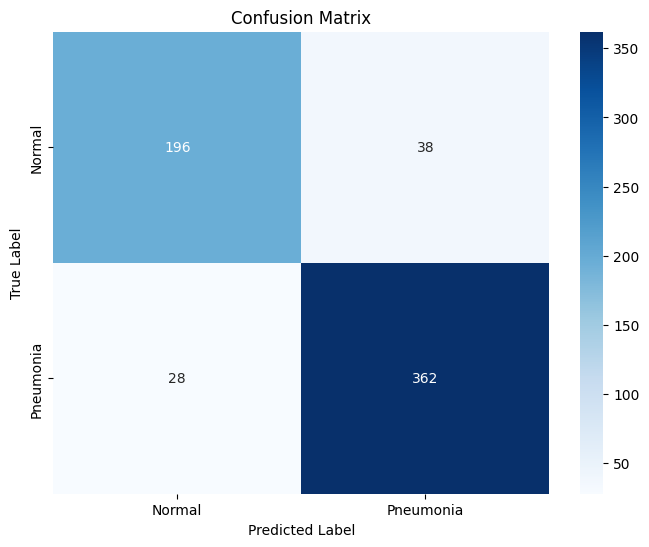

In [10]:
# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Visualization with TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 21730), started 0:11:32 ago. (Use '!kill 21730' to kill it.)

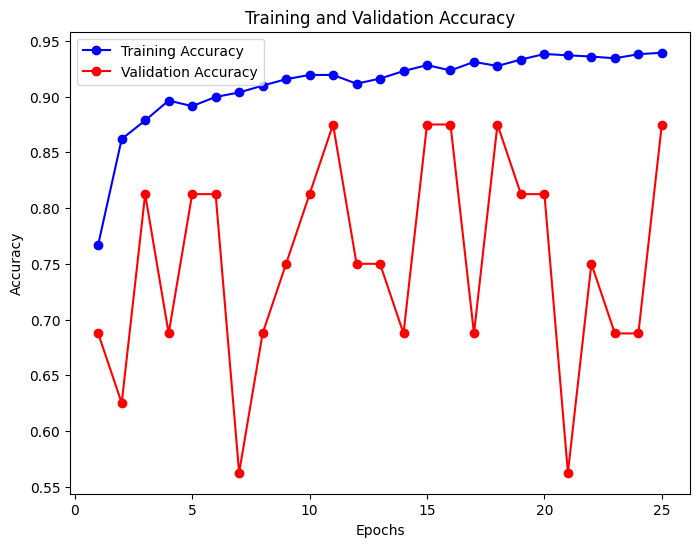

In [12]:
import matplotlib.pyplot as plt

# Assuming 'history' is the History object returned by model.fit()
history_dict = history.history

# Extract training and validation accuracies
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Extract the number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training accuracy vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
